#  La malédiction de la dimension et les modèles max-margin

Quelques liens pour plus de détails :
* [Overfitting](https://github.com/maximiliense/lmpirp/blob/main/Notes/Overfitting.pdf)
* [KNN](https://github.com/maximiliense/lmpirp/blob/main/Notes/KNN.pdf)
* [SVM](https://github.com/maximiliense/lmpirp/blob/main/Notes/SVM.pdf)

## Introduction

Comme nous avons pu le voir lors des TPs précedents, l'objectif de l'apprentissage est de trouver une fonction $f\in\mathcal{H}$ de $\mathcal{X}\mapsto\mathcal{Y}$ telle que le risque de généralisation $R:\mathcal{H}\mapsto\mathbb{R}^+$ est minimisé :
\begin{equation}
f=\text{argmin}_{h\in\mathcal{H}}R(h)
\end{equation}

Le risque de généralisation est défini comme l'espérance d'un risque élémentaire $r$ (qui dépend de la tâche que l'on souhaite résoudre) :
\begin{equation}
R(h)=\mathbb{E}_{X\times Y}\Big[r(h(X), Y)\Big]
\end{equation}

Ce calcul d'espérance est bien entendu impossible, ne serait-ce que par ce que nous ne connaissons pas la loi de $X\times Y$... La stratégie de l'apprentissage statistique consiste à s'appuyer sur un risque dit empirique ; un risque calculé à partir d'un certain nombre d'exemples d'apprentissages que l'on notera $\mathcal{S}=\{(\boldsymbol{x_i}, y_i)\}_{i\leq n}$ :
\begin{equation}
Re(h)=\frac{1}{n}\sum_{i=1}^n r\big(h(\boldsymbol{x_i}), y_i\big)
\end{equation}

Le risque empirique, est un estimateur sans biais du risque de généralisation pour un $h$ quelconque. Cependant, nous sommes intéressé par un $\hat{h}\in\mathcal{H}$ particulier : celui qui minimise le risque empirique :

\begin{equation}
\hat{h}=\text{argmin}_{h\in\mathcal{H}}Re(h).
\end{equation}

Dans le cadre de la régression linéaire, logistique, etc. nous avons pu voir que $\mathcal{H}$ était construit de manière paramétrique et que l'optimisation se faisait soit analytiquement, soit au travers de de l'algorithme de descente de gradient.

**Il convient de faire attention**. Comme nous avons pu le constater dans les TPs précedents, le risque empirique **n'est pas** un estimateur sans biais du risque de généralisation pour $\hat{h}$. Nous avons pu observer des scénarios où $Re(h)=0$ alors que le risque de généralisation atteignait des valeurs catastrophiques. De manière plus rigoureuse, le gap de généralisation est l'écart entre notre risque empirique de notre estimateur $\hat{h}$ et son risque de généralisation :
\begin{equation}
\text{gap}(\hat{h})=|Re(\hat{h})-R(\hat{h})|.
\end{equation}

Il est possible d'avoir une idée de $R(\hat{h})$ en passant par un jeu de test ou autre stratégies d'évaluation.


Deux facteurs principaux sont admis comme entrant en jeu : 
* la taille de l'ensemble $\mathcal{H}$ qui est généralement liée au nombre de paramètres de notre modèle,
* la taille du jeu de données $\mathcal{S}$.

Plus $\mathcal{H}$ est grand, plus on s'attend à voir l'erreur augmenter. L'effet de double descente montre qu'avec un choix réfléchi de paramétrisation, cette tendance n'est pas nécessairement monotone. De la même manière, augmenter la taille du jeu de données $\mathcal{S}$ permet de réduire l'erreur de généralisation.

La taille de $\mathcal{H}$ est intrinsèquement liée au nombre de paramètres qui lui-même dépend très souvent de la dimension $d$ de nos données. La première partie de ce TP se concentrera sur ce qu'on appelle la *malédiction de la dimension* et la seconde partie sur la notion de *max-margin*.

## La malédiction de la dimension

La malédiction de la dimension fait référence aux résultats contre-intuitifs qui apparaissent lorsque la dimension augmente. Une première manière de l'observer est possible grâce au KNN. Ce dernier classe un nouvel élément en fonction de ses voisins dans le jeu d'apprentissage. Nous allons en particulier étudier l'évolution du risque de généralisation en fonction de la dimension. Plus précisément, les données sont construites de la manière suivante :

In [8]:
import numpy as np
def sample_data(n, k=3, d=50, mu=1):
    y = np.random.randint(0, 2, size=(n, 1))
    
    X = np.random.normal(mu, 1, size=(n, k))
    X = y*X-(1-y)*X # positive have mean mu and negative, -mu
    noise = np.random.normal(0, 1, size=(n, d-k))
    X = np.concatenate([X, noise], axis=1)
    
    return X, y

Dit autrement, $k$ dimensions contiennent le signal intéressant pour notre tâche et $d$ dimensions ne servent à rien. Nous observons ci-dessous ce qui se passe lorsqu'on rajouter des dimensions de bruits (i.e. qui ne servent à rien).

In [9]:
from sklearn.neighbors import KNeighborsClassifier

scores = []
redo = 5
max_dim = 5000
first_dim = 10
steps = 100

for d in range(first_dim, max_dim, steps):
    s = 0
    for _ in range(redo):
        X, y = sample_data(100, d=d)
        X_test, y_test = sample_data(200, d=d)
        c = KNeighborsClassifier()
        c.fit(X, y.reshape((y.shape[0],)))
        s += c.score(X_test, y_test.reshape((y_test.shape[0],)))/redo
    scores.append(s)

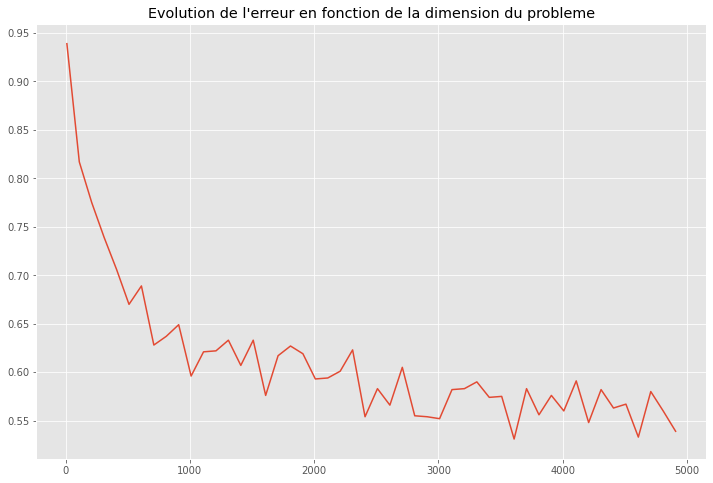

In [10]:
import matplotlib
import matplotlib.pyplot as plt

# configuration generale de matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('ggplot')

plt.plot(list(range(first_dim, max_dim, steps)), scores)
plt.title('Evolution de l\'erreur en fonction de la dimension du probleme')
plt.show()

---

<span style="color:blue">**Exercice 1 :**</span> **Quelle est le risque de généralisation pour l'erreur 0/1 (1 si la classe est mal prédite, 0 sinon) d'un classifieur aléatoire ?**

<span style="color:green">**Réponse : une chance sur deux (asymptote à 0.5) **</span>

<span style="color:blue">**Exercice 2 :**</span> **Expliquez pourquoi l'erreur de généralisation déminimue lorsqu'on rajoute des dimensions sans signal.**

<span style="color:green">**Réponse : **</span>

---

De manière similaire, affichons ci-dessous l'évolution des distances entre nos points en fonction de la dimension du problème.

In [5]:
import numpy as np

def sample_data(n, d):
    return np.random.uniform(-1, 1, size=(n, d))/np.sqrt(d)
X = sample_data(100, 10)

In [6]:
redo = 50
def experiment_(d):
    min_ = 0
    max_ = 0
    mean_ = 0
    for _ in range(redo):
        X = sample_data(100, d)
        vec = np.sqrt((X**2).sum(axis=1))
        min_ += vec.min()/redo
        max_ += vec.max()/redo
        mean_ += vec.mean()/redo
    return min_, max_, mean_
idx = []
val = []
for d in range(10, 1000, 100):
    idx.append([d])
    val.append(experiment_(d))
for d in range(2000, 10000, 1000):
    idx.append([d])
    val.append(experiment_(d))
arr = np.concatenate([np.array(idx), np.array(val)], axis=1)

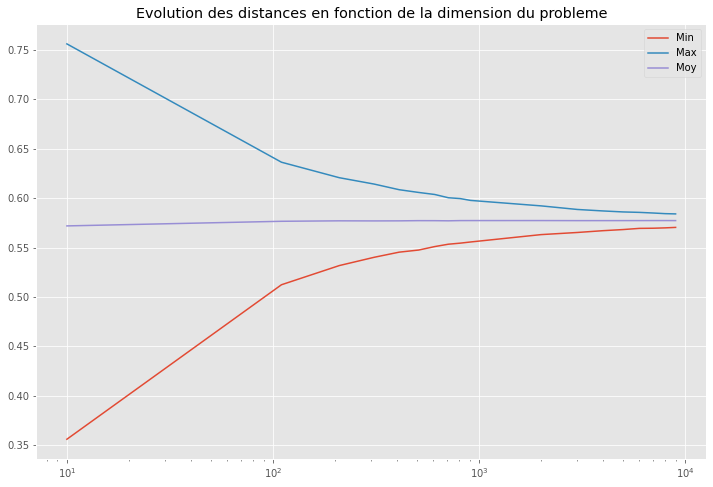

In [7]:
plt.figure()
plt.plot(arr[:, 0], arr[:, 1], label='Min')
plt.plot(arr[:, 0], arr[:, 2], label='Max')
plt.plot(arr[:, 0], arr[:, 3], label='Moy')
plt.legend()
plt.title('Evolution des distances en fonction de la dimension du probleme')
plt.xscale('log')

---
<span style="color:blue">**Exercice 3 :**</span> **Quelle phénomène mathématique pouvons nous invoquer afin d'expliquer ce phénomène ?**

<span style="color:green">**Réponse : + on augmente la dimension, plus les données ont des valeurs chelou, ça c'est la malédiction**</span>

---

# Machine à vecteurs de support ou l'hypothèse du *max-margin*

L'hypothèse implicite derrière le *max-margin* est qu'entre deux frontières de même complexité, la plus robuste aux perturbations (dans le sens où si on perturbe un élément du train la probabilité qu'il change de classe est la plus faible) est la meilleure. L'idée fait sens car on peut supposer que les échantillons nouveaux peuvent être vus comme des perturbations des échantillons du jeu d'apprentissage. 

La frontière la plus robuste aux perturbations est celle qui maximise la distance entre le point le plus proche et elle-même. C'est l'hypothèse du *max-margin*.

Le SVM, ou machine à vecteurs de support adopte cette stratégie. Une présentation plus détaillée du SVM est disponible à l'adresse suivante : [SVM](https://github.com/maximiliense/lmpirp/blob/main/Notes/SVM.pdf).

## Introduction

### Un problème de classification linéaire

Le SVM est un classifieur linéaire. Soit $\mathcal{X}\subset\mathbb{R}^d$ nos variables d'entrées et $\mathcal{Y}=\{-1,+1\}$ nos variable à prédire. Un classifieur linéaire sépare les éléments de notre jeu de données par un hyperplan. Comme vous avez pu le voir dans le TP précédent, un hyperplan décrit par le vecteur normal $w$ est défini par les solutions de l'équations suivantes :
\begin{equation}
\langle w, x\rangle = 0
\end{equation}

Si le produit scalaire est positif, on dira que notre échantillon $x$ appartient à la classe positive et inversement.

Un classifieur linéaire peut donc être décrit de la manière suivante :

\begin{equation}
\begin{aligned}
h_w:\mathcal{X}&\mapsto\mathcal{Y}=\{-1,+1\}\\
x&\rightarrow \text{sign}(\langle w, x\rangle)
\end{aligned}
\end{equation}

De la même manière que pour les TPs précédents, on peut introduire la notion de biais en rajoutant une dimension de $1$ aux vecteurs $x$.

---
<span style="color:blue">**Petite question d'algèbre :**</span> **Trouvez le projecteur orthogonal de $\mathcal{X}$ sur l'hyperplan décrit par le vecteur $w$, noté $\text{proj}_w(x)$. Démontrez que $\forall x\in\mathcal{X},\ \text{proj}_w(x)\in\{z:\langle w, z\rangle=0\}$ (autrement dit, démontrez que la projection de $x$ sur la frontière est bien sur la frontière).**

<span style="color:green">**Réponse :**</span> 



<span style="color:blue">**Petite question d'algèbre 2 :**</span> **Montrer que $\text{proj}_w^2=\text{proj}_w$ (le carré est pris dans le sens de la composition). Cela vous semble-t-il logique ?**

<span style="color:green">**Réponse :**</span> 



---

### Le primal

Comme dit plus haut, on ne cherche pas n'importe quel hyperplan, mais bien celui qui rang la marge maximale. La marge est définie par la plus patite distance entre un point du jeu de données et la frontière de décision.

La distance d'un point à la frontière est donnée par $|\langle x_i, w\rangle|$ ($w$ unitaire). La quantité $y_i\langle x_i, w\rangle$ est positive et indique la distance à la frontière si le point est bien classé et donne la distance négative si le point est mal classé. Ainsi $\min_{i\leq m} y_i\langle x_i, w\rangle$ nous donne le point la plus petite distance (négative si mal classé).

On souhaite donc trouver $w$ tel que cette distance soit maximale (i.e. le point le plus proche est le plus loin possible de la frontière) :
\begin{equation}
\hat{w}=\text{argmax}_{w, ||w||=1}\min_{i\leq m}y_i\langle x_i, w\rangle
\end{equation}

Il est possible de montrer que le vecteur $w=w_0/||w_0||$ tel que :
$$w_0=\text{argmin}_{w}||w||^2_2,\ s.t. \forall i\leq m,\ y_i\langle x_i, w\rangle \geq 1$$
est solution de ce problème de minimisation.

Remarquez que cela fait penser à la régularisation : parmi toutes les solutions possibles, on cherche celle de norme minimale.

### Le dual (optionnel)

Le problème d'optimisation si dessus est ce qu'on appelle un problème d'optimisation sous contrainte. Un tel problème est associé à ce qu'on appelle un Lagrangien :
$$\mathcal{L}(w, \alpha)=||w||_2^2+\sum_{i=1}^m\alpha_i(1-y_i\langle x_i, w\rangle),\ \alpha_j\geq 0, j\leq m$$

Notons $g(w)=\max_{\alpha,\alpha\geq 0}\mathcal{L}(w,\alpha)$. On observe assez rapidement que $g(w)=\infty$ si une des contraintes n'est pas satisfaite et vaut $||w||^2_2$ sinon.

Ainsi, minimiser $g(w)$ revient à minimiser la norme du vecteur $w$ en respectant les contraintes. C'est ce qu'on appelle le *primal* qu'on note $p^\star$ :
$$p^\star=\min_w\max_{\alpha,\alpha\geq 0}\mathcal{L}(w,\alpha)$$

Le passage au dual permet d'inverser la minimisation et la maximisation. Il n'est pas évident de montrer que les deux problèmes sont équivalents. C'est ici le cas et on note $d^\star$ le dual (on parle donc de dualité forte) :
$$d^\star=\max_{\alpha,\alpha\geq 0}\min_w\mathcal{L}(w,\alpha).$$

Quelques éléments de calculs plus loin (le minimum est un point critique, on annule les dérivées partielles, etc.), on reformule le dual de la manière suivante :
$$\max_{\alpha,\alpha\geq 0}\sum_i\alpha_i-\frac{1}{2}\sum_i\sum_j\alpha_i\alpha_jy_iy_j\langle x_i, x_j\rangle$$

et

$$w=\frac{1}{2}\sum_i \alpha_iy_ix_i$$

Ainsi, notre modèle prédictif prend la forme suivante :

\begin{equation}
\begin{aligned}
h:\mathcal{X}&\mapsto\mathcal{Y}\\
x&\rightarrow\text{sign}(\sum_i\alpha_iy_i\langle x_i, x\rangle)
\end{aligned}
\end{equation}

### L'astuce du noyau (optionnel, suite du dual)

L'astuce du noyau découle de la formation duale et notamment du fait que celle-ci n'est liée aux données qu'au travers du produit $y_iy_i$ et du produit scalaire $\langle x_i, x_j\rangle$. Si le problème de classification est non linéaire, il est possible de passer par une transformation non linéaire $\phi:\mathcal{X}\mapsto\mathcal{F}$ de nos données d'entrées. Le problème devient donc :
$$\max_{\alpha,\alpha\geq 0}\sum_i\alpha_i-\frac{1}{2}\sum_i\sum_j\alpha_i\alpha_jy_iy_j\langle \phi(x_i), \phi(x_j)\rangle$$

Sans rentrer dans les détails, l'astuce du noyau vient de l'existence de fonctions :
\begin{equation}
\begin{aligned}
k:\mathcal{X}\times\mathcal{X}&\mapsto\mathbb{R}\\
x_i,x_j&\rightarrow k(x_i,x_j)=\langle\phi(x_i),\phi(x_j).
\end{aligned}
\end{equation}

Ces fonctions $k$ ne nécessitent pas de projeter les $x$ dans un espace de plus grande dimension et permettent d'obtenir le résultat du produit scalaire directement dans l'espace d'origine. Ainsi, on peut même calculer le produit scalaire dans des espaces de dimensions infinies.

Par exemple le noyau :
$$k(x_i, x_j)=(\langle x_i, x_j\rangle+c)^n,$$
nous permet de faire une transformations polynomiales de degré $n$ directement dans l'espace d'origine ; on remarque que la puissance $n$ est calculée sur le résultat du produit scalaire ($+c$) qui est donc un sclaire.

## Visualisation de la frontière de décision

L'objectif de ce premier exercice est de visualiser la frontière de décision d'un SVM en jouant sur un exemple simple avec les noyaux offerts par la librairie $\texttt{scikit-learn}$.

La visualisation suivante permet d'observer la marge et notamment les vecteurs de supports.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
np.random.seed(0)

dataset_size = 20

X = np.r_[np.random.randn(dataset_size, 2) - [2, 2], np.random.randn(dataset_size, 2) + [2, 2]]
Y = [0] * dataset_size + [1] * dataset_size

# figure number
fignum = 1

kernel = 'linear'
clf = svm.SVC(kernel=kernel)
clf.fit(X, Y)

# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]

# plot the parallels to the separating hyperplane that pass through the
# support vectors (margin away from hyperplane in direction
# perpendicular to hyperplane). This is sqrt(1+a^2) away vertically in
# 2-d.
margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin

# plot the line, the points, and the nearest vectors to the plane
plt.figure(figsize=(14, 8))
plt.clf()
plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')

plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
            facecolors='none', zorder=10, edgecolors='k')

plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired,
            edgecolors='k')

plt.axis('tight')
x_min = -4.8
x_max = 4.2
y_min = -6
y_max = 6

XX, YY = np.mgrid[x_min:x_max:500j, y_min:y_max:500j]
Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.pcolormesh(XX, YY, Z, cmap=plt.cm.Paired, shading='auto')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(())
plt.yticks(())
plt.show()


In [ ]:
def sample_data(size=80):
    X = np.random.uniform(-1, 1, size=(200, 2))
    y = X[:, 0]**3 < X[:, 1]
    return X, y
X, y = sample_data()

In [ ]:
def plot(X, y, clf=None):
    plt.figure(figsize=(14, 8))
    plt.xticks(())
    plt.yticks(())
    if clf is not None:

        XX, YY = np.mgrid[-1:1:500j, -1:1:500j]
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.pcolormesh(XX, YY, Z, cmap=plt.cm.Paired, shading='auto')

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    plt.scatter(X[:, 0], X[:, 1], c=y)

    plt.show()

In [ ]:
plot(X, y)

Voici la visualisation d'un SVM avec un noyau linéaire (un produit scalaire $\langle\cdot,\cdot\rangle$).

In [ ]:
kernel = 'linear'
clf = svm.SVC(kernel=kernel)
clf.fit(X, y)

plot(X, y, clf)

Comme vous avez pu le voir, si vous avez lu la section concernant le dual, le SVM permet de remplacer les comparaisons linéaires (i.e. le produit scalaire), par des comparaisons non-linéaires (i.e. produit scalaire dans un espace où les données sont projetées non linéairement). La librairie $\texttt{scikir-learn}$ permet de jouer avec ce paramètre.

---
<span style="color:blue">**Exercice 4 :**</span> **Jouez avec plusieurs noyaux et observez la forme de la frontière de décision.**

---

In [ ]:
####### Complete this part ######## or die ####################

###############################################################

---
<span style="color:blue">**Question :**</span> **Comparez la robustesse d'un SVM par rapport à un 1NN relativement à la dimension du problème. Le SVM est-il plus ou moins robuste que le 1NN ?**

<span style="color:green">**Réponse :**</span>

---

In [ ]:
####### Complete this part ######## or die ####################

###############################################################

## Sur de vrais données

---
<span style="color:blue">**Exercice 5 :**</span> **Utilisez le SVM, la régression logistique ou encore le KNN pour résoudre les problèmes ci-dessous.**

---

### Iris dataset

In [1]:
from sklearn import datasets
iris = datasets.load_iris()

X = iris['data']
y = iris['target']

In [6]:
####### Complete this part ######## or die ####################
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.1)

kernels = ['poly','rbf','sigmoid']
params = [
    {'kernel': ['linear']},
    {'kernel': ['poly'],'degree': [1,2,3,4,5], 'coef0': [1,2,3,4,5], 'gamma': ['auto']},
    {'kernel': ['rbf'], 'gamma': ['scale']},
    {'kernel': ['sigmoid'], 'gamma': ['auto'], 'coef0': [0.1,1.,10.]}

]

search = GridSearchCV(svm.SVC(), params, cv=5)
search.fit(Xtrain, ytrain)
print('Train'+ '*' * 50)
print(classification_report(ytrain.reshape((ytrain.shape[0],1)), search.predict(Xtrain)))
print('Test'+ '*' * 50)
print(classification_report(ytest.reshape((ytest.shape[0],1)), search.predict(Xtest)))

###############################################################

Train**************************************************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.98      0.98      0.98        45
           2       0.98      0.98      0.98        45

    accuracy                           0.99       135
   macro avg       0.99      0.99      0.99       135
weighted avg       0.99      0.99      0.99       135

Train**************************************************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       0.83      1.00      0.91         5

    accuracy                           0.93        15
   macro avg       0.94      0.93      0.93        15
weighted avg       0.94      0.93      0.93        15



### Digits dataset

In [20]:
from sklearn import datasets
digit = datasets.load_digits()

X = digit['data']
Y = digit['target']

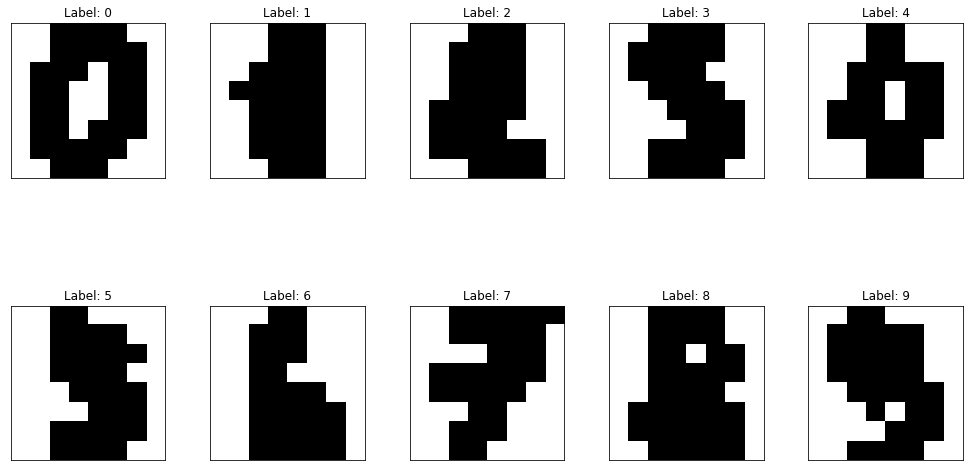

In [21]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 8))
fig.tight_layout()
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = X[i].reshape((8, 8))
    plt.xticks(())
    plt.yticks(())
    
    plt.imshow(img, cmap='gray_r', vmin=0, vmax=1)
    plt.title('Label: '+str(Y[i]))
plt.show()

In [23]:
####### Complete this part ######## or die ####################
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.3)

kernels = ['poly','rbf','sigmoid']
params = [
    {'kernel': ['poly'],'degree': [1,2,3,4,5], 'coef0': [1,2,3,4,5], 'gamma': ['auto']},
    {'kernel': ['rbf'], 'gamma': ['scale']},
    {'kernel': ['sigmoid'], 'gamma': ['auto'], 'coef0': [0.1,1.,10.]}

]

search = GridSearchCV(svm.SVC(), params, cv=5)
search.fit(Xtrain, ytrain)
print('Train'+ '*' * 50)
print(classification_report(ytrain.reshape((ytrain.shape[0],1)), search.predict(Xtrain)))
print('Test'+ '*' * 50)
print(classification_report(ytest.reshape((ytest.shape[0],1)), search.predict(Xtest)))

###############
###############################################################

ValueError: Found input variables with inconsistent numbers of samples: [1797, 150]

### Wine dataset

In [17]:
from sklearn import datasets
wine = datasets.load_wine()

X = wine['data']
Y = wine['target']

In [18]:
####### Complete this part ######## or die ####################
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.1)

kernels = ['poly','rbf','sigmoid']
params = [
    {'kernel': ['linear']},
    {'kernel': ['poly'],'degree': [1,2,3,4,5], 'coef0': [1,2,3,4,5], 'gamma': ['auto']},
    {'kernel': ['rbf'], 'gamma': ['scale']},
    {'kernel': ['sigmoid'], 'gamma': ['auto'], 'coef0': [0.1,1.,10.]}

]

search = GridSearchCV(svm.SVC(), params, cv=5)
search.fit(Xtrain, ytrain)
print('Train'+ '*' * 50)
print(classification_report(ytrain.reshape((ytrain.shape[0],1)), search.predict(Xtrain)))
print('Test'+ '*' * 50)
print(classification_report(ytest.reshape((ytest.shape[0],1)), search.predict(Xtest)))

###############################################################

ValueError: Found input variables with inconsistent numbers of samples: [178, 150]